## Import packages

In this project we were using **Tensorflow 2.2.0** which is latest stabile Tensorflow version as of the time of writing this article.

The auxiliary packages are as follows:
- **numpy:** Numeric processing, especially n-dimensional matrix
- **matplot:** Image visualization and mathematical plots
- **tensorflow_addons:** Adds-on and extension of Tensorflow

In [0]:
# Make sure that you are working on CUDA-enabled GPUs if any available
!nvidia-smi

Mon May 25 01:38:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    44W / 250W |   4681MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

print('Tensorflow: {0}'.format(tf.__version__))
print('Keras: {0}'.format(tf.keras.__version__))

Tensorflow: 2.2.0
Keras: 2.3.0-tf


# **Data loading and preprocessing**

Keras is providing some very basic but common [built-in datasets](https://keras.io/api/datasets/).  
For vision, MNIST, Fashin-MNIST, CIFAR10 and CIFAR100 is available.  
This is a very concinient way to load basic datasets for fast prototyping, and Keras will download (if necessary), extract and load the dataset.  

However, if it is required to work with more complex and customised datasets, modified dataloader is needed. This can be done in several ways including [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In this article [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is used. This dataset has 60 000 and 10 000 images for training and test, respectively. Each image has the resolution of 28x28x1 with a pixel range between 0 and 255.  

In most scenarios, it is desirable to have individual and isolated sets. A common split is as follows:  
- **Train:** This will be used during the training process. It is very common to perform different augmentation on this set to generate more images. For instance an image can be cropped, flipped and roatated with arbitary parameters to have more images for training.
- **Validation:** During the training, it is desirable to monitor the model's performance with appropriate metrics or even in some cases visually. This monitoring process can be done between training steps, for instance at the end of each epoch. This set can be used for this reason. It is not common to perform any augmentation on this set.
- **Test:** Once the training process is finished, the model should be tested on a set which has not been seen before. This will verify the generalization of the model. A good model which is not overfitted and memorized should perform well under this condition.



In [0]:
IMAGE_DIMENSION = 28

In [0]:
# Download and load Fashion MNIST from Keras built-in datasets 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Spliting the training set into training and validation with a ratio of 0.8 : 0.2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

print('Training set:   \t Input {0} -\t Output {1}'.format(x_train.shape, y_train.shape))
print('Validation set: \t Input {0} -\t Output {1}'.format(x_val.shape, y_val.shape))
print('Test set:       \t Input {0} -\t Output {1}'.format(x_test.shape, y_test.shape))

Training set:   	 Input (48000, 28, 28) -	 Output (48000,)
Validation set: 	 Input (12000, 28, 28) -	 Output (12000,)
Test set:       	 Input (10000, 28, 28) -	 Output (10000,)


In [0]:
labels_desc = {0: 'T-shirt/top',
               1: 'Trouser',
               2: 'Pullover',
               3: 'Dress',
               4: 'Coat',
               5: 'Sandal',
               6: 'Shirt',
               7: 'Sneaker',
               8: 'Bag',
               9: 'Ankle boot'}

## Normalization

A neural network can take multiple features where each can have different properties such as types, scale, range etc. A feature should not affect the network because of its characteristic such as range if this is not desired. Hence all features should be normalized so that each feature is within the appropriate range and scale.  

In addiiton to the normalization, neural network are working better with floating-points for more accuracy and performance. Floating-point 16 or 32 is widly used for parameters and in training. However, other datatypes and precision can be desireable depending on the hardware constrains and GPU optimization.

The being said, there are two type of normalization that is commonly used for neural networks.

- Normalize the features with a range of [0 : +1]  
- Normalize the features with respect to its mean and variance. The equation is as follows:  
<img src="https://latex.codecogs.com/svg.latex?\Large&space;x=\frac{x - \mu}{\sigma}" />  
where mu is the mean and sigma is the variance of the feature.  
*Note that in the most cases each channel is calculcated individual and independed to each other.*



In [0]:
# Normalization
# The features in Fashion MNIST [0:255]

# Normalize images from [0:255] -> [0:1] and convert it to 32-bit floating-points
x_train = x_train / 255.0
x_train = x_train.astype(np.float32)
x_train = np.expand_dims(x_train, axis=-1)

x_val = x_val / 255.0
x_val = x_val.astype(np.float32)
x_val = np.expand_dims(x_val, axis=-1)

x_test = x_test / 255.0
x_test = x_test.astype(np.float32)
x_test = np.expand_dims(x_test, axis=-1)

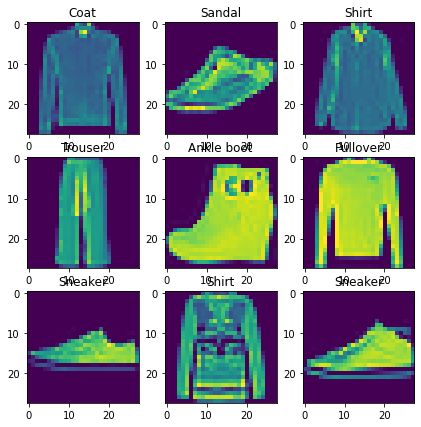

In [0]:
# Plot random images from training set
random_idx = np.random.randint(0, len(x_train), 9)

_, axs = plt.subplots(3, 3, figsize=(IMAGE_DIMENSION // 4, IMAGE_DIMENSION // 4))
axs = axs.flatten()
for idx, ax in zip(random_idx, axs):
    image = np.squeeze(x_train[idx])
    label = labels_desc[y_train[idx]]
    ax.imshow(image)
    ax.set_title(label)
plt.show()

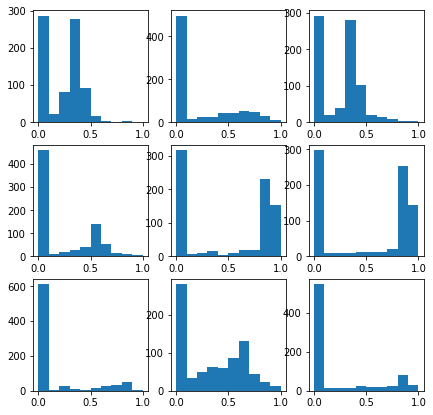

In [0]:
# The histogram should show the range of pixel values along with its frequency of occurrence
# In this way we can observe that our pixel values are within the desirable range

_, axs = plt.subplots(3, 3, figsize=(IMAGE_DIMENSION // 4, IMAGE_DIMENSION // 4))
axs = axs.flatten()
for idx, ax in zip(random_idx, axs):
    image = x_train[idx].flatten()
    ax.hist(image, bins=10)
plt.show()

# Dataloader

## Data augmentation

Data is one of the major and important component in deep learning but in most common cases the training data is limited. Hence we need to try to reproduce more examples in respect and based on the available data.  
Another important reason is that we want to make our model generalized as much as possible. We want a model that is performonig great on unseen and unfamiliar data and prevent a model to memorize a mapping.  
Limited available data along with poor regularization techniqes will make the model to overfit which means that the model is working great on training set, but failing once it is evaluated on unseen data such as test set.  
Data augmentation is very important part of preprocessing and can be a major help for preventing a model to overfit on limited data.

There are mulitple data augmentation techniques depending on the feature type and its charactersitc. Some of the common data augmentation on images are mentioned in list belows:

- **Flip:** The image can be randomly flipped either up and down or left or right.
- **Rotation:**: Random rotation within a certain of degree.
- **Brightness**: Makes the image more or less brighter. In the case of grayscale images, it scales the pixel values.
- **Channel shifting**: Shifting channels when the image has multiple channels such as 3-channels (RGB).

*Note that in some cases we want to maintain characteristic of the image such as natural images. Hence some augmentation techniques may not be appropriate.*

More advavanced augmentations:
-

In [0]:
def data_augmentation(image):
    # Rotation
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Random flip: {up or down, left or right}
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image

In [0]:
BATCH_SIZE = 1024
REPEAT_DATASET_PER_EPOCH = 10

# Dataloader
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.map(data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=10_000)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat(REPEAT_DATASET_PER_EPOCH)
train_dataset = train_dataset.prefetch(BATCH_SIZE)

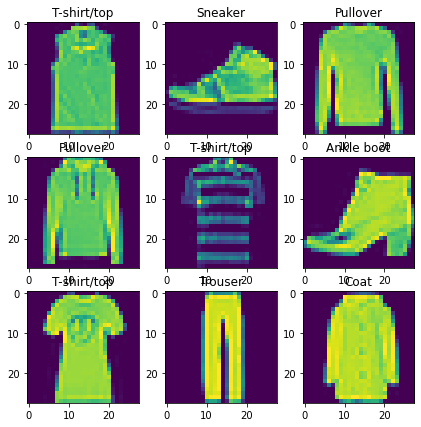

In [0]:
images = train_dataset.take(9)

_, axs = plt.subplots(3, 3, figsize=(IMAGE_DIMENSION // 4, IMAGE_DIMENSION // 4))
axs = axs.flatten()
for idx, (image, ax) in enumerate(zip(images, axs)):
    image = np.squeeze(x_train[idx])
    label = labels_desc[y_train[idx]]
    ax.imshow(image)
    ax.set_title(label)
plt.show()

# **Autoencoder**

In [0]:
LATENT_DIMENSION = 100

## Loss

In [0]:
def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean((y_true - y_pred)**2)

## Encoder

In [0]:
class Encoder(tf.keras.Model):

    def __init__(self, latent_dim=1024, *args, **kwargs):
        super(Encoder, self).__init__(*args, **kwargs)
        self.latent_dim = latent_dim

        # Layers
        self.conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same')
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same')
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same')
        self.bn_3 = tf.keras.layers.BatchNormalization()
        self.dense_1 = tf.keras.layers.Dense(units=self.latent_dim)

    def call(self, inputs):
        # Convlution 1
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.keras.activations.relu(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
        # Convlution 2
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = tf.keras.activations.relu(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
        # Convlution 3
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = tf.keras.activations.relu(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
        # Dense
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_1(x)

        return x

## Decoder

In [0]:
class Decoder(tf.keras.Model):

    def __init__(self, latent_dim=1024, *args, **kwargs):
        super(Decoder, self).__init__(*args, **kwargs)
        self.latent_dim = latent_dim

        # Layers
        self.dense_1 = tf.keras.layers.Dense(units=2048)
        self.conv_trans_1 = tf.keras.layers.Conv2DTranspose(filters=128, 
                                                            kernel_size=3, 
                                                            strides=2,
                                                            padding='same')
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.conv_trans_2 = tf.keras.layers.Conv2DTranspose(filters=64,
                                                            kernel_size=3, 
                                                            strides=2,
                                                            padding='same')
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.conv_1 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same')

    def call(self, inputs):
        # Dense
        x = self.dense_1(inputs)
        x = tf.keras.activations.relu(x)
        x = tf.keras.layers.Reshape((8, 8, 32))(x)
        # Transpose Convolution 1
        x = self.conv_trans_1(x)
        x = self.bn_1(x)
        x = tf.keras.activations.relu(x)
        # Transpose Convolution 2
        x = self.conv_trans_2(x)
        x = self.bn_2(x)
        x = tf.keras.activations.relu(x)
        # Convlution 1
        x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)
        x = self.conv_1(x)
        x = tf.keras.activations.sigmoid(x)

        return x

## Autoencoder

In [0]:
class Autoencoder(tf.keras.Model):

    def __init__(self, encoder_cls, decoder_cls, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = encoder_cls(self.latent_dim, name='Encoder')
        # Decoder
        self.decoder = decoder_cls(self.latent_dim, name='Decoder')
        
    def compile(self, optimizer, loss):
        super(Autoencoder, self).compile()
        self.optimizer = optimizer
        self.loss = loss

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

    def train_step(self, images):
        with tf.GradientTape() as tape:
            latent_vector = self.encoder(images)
            reconstruction = self.decoder(latent_vector)
            loss = self.loss(images, reconstruction)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {'loss': loss}


In [0]:
autoencoder = Autoencoder(encoder_cls=Encoder, decoder_cls=Decoder, 
                          latent_dim=LATENT_DIMENSION)
# Optimizer, loss
adam_optimizer = tf.keras.optimizers.Adam()
autoencoder.compile(optimizer=adam_optimizer, loss=mean_squared_error)

In [0]:
# Inference
noise = tf.random.normal(shape=[1, IMAGE_DIMENSION, IMAGE_DIMENSION, 1])
reconstruction = autoencoder(noise)
print('Input: {0} - Output: {1}'.format(noise.shape, reconstruction.shape))
autoencoder.summary()

Input: (1, 28, 28, 1) - Output: (1, 28, 28, 1)
Model: "autoencoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder (Encoder)            multiple                  208868    
_________________________________________________________________
Decoder (Decoder)            multiple                  318977    
Total params: 527,845
Trainable params: 527,013
Non-trainable params: 832
_________________________________________________________________


## Callbacks

In [0]:
class DigitPlotCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch % 2) != 0:
            return
            
        random_idx = np.random.randint(0, len(x_val), 2)
        image = x_val[random_idx]
        reconstruction = self.model(image)

        fig = plt.figure()
        plot_counter = 1
        for idx in range(0, 2):
            ax = fig.add_subplot(2, 2, plot_counter)
            ax.imshow(np.squeeze(image[idx]))
            plot_counter = plot_counter + 1

            ax = fig.add_subplot(2, 2, plot_counter)
            ax.imshow(np.squeeze(reconstruction[idx]))
            plot_counter = plot_counter + 1

digit_plot_callback = DigitPlotCallback()

In [0]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,
                                                      embeddings_freq=1)

## Train

Epoch 1/10
470/470 [==============================] - 48s 103ms/step - loss: 0.0337
Epoch 2/10
470/470 [==============================] - 48s 103ms/step - loss: 0.0147
Epoch 3/10
470/470 [==============================] - 49s 104ms/step - loss: 0.0121
Epoch 4/10
470/470 [==============================] - 49s 104ms/step - loss: 0.0107
Epoch 5/10
470/470 [==============================] - 48s 103ms/step - loss: 0.0098
Epoch 6/10
470/470 [==============================] - 49s 105ms/step - loss: 0.0091
Epoch 7/10
470/470 [==============================] - 49s 105ms/step - loss: 0.0086
Epoch 8/10
470/470 [==============================] - 48s 103ms/step - loss: 0.0082
Epoch 9/10
470/470 [==============================] - 48s 103ms/step - loss: 0.0078
Epoch 10/10
470/470 [==============================] - 48s 102ms/step - loss: 0.0075


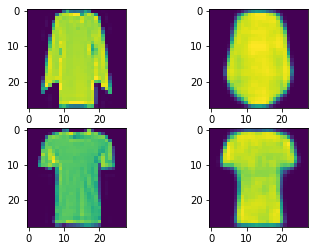

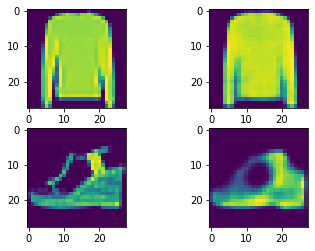

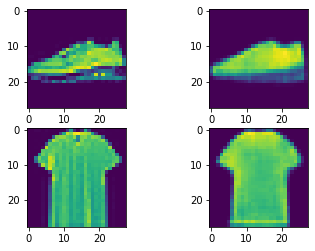

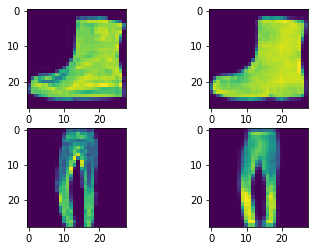

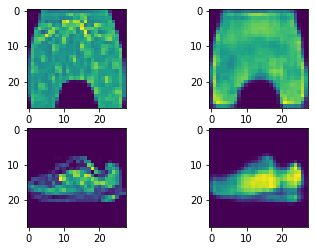

In [0]:
EPOCH_SIZE = 10
history  = autoencoder.fit(train_dataset, epochs=EPOCH_SIZE, 
                callbacks=[digit_plot_callback, tensorboard_callback])

In [0]:
print(history.history.keys())
print(history.history['loss'])
plt.plot(list(range(EPOCH_SIZE)), history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train',], loc='upper left')
plt.show()

In [0]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard
# %tensorboard --logdir logs


# Visualization

In [0]:
# Find test images according to their labels
labels = []
for idx in range(10):
    idx_labels = np.where(test_y == idx)
    idx_labels = np.squeeze(np.array(idx_labels))
    labels.append(idx_labels)
labels = np.array(labels)

In [0]:
mean_latent_vectors = []

plt.figure(figsize=(12, 12))
for idx in range(10):
    images = test_x[labels[idx]]
    latent_vector = autoencoder.encoder(images)
    latent_vector = np.swapaxes(latent_vector, 0, 1)
    x, y = latent_vector
    plt.scatter(x, y, marker='o', s=8, label=str(idx))
    plt.legend()

    # Calculcate the mean of each label
    mean_latent_vectors.append({'mean': [np.mean(x), np.mean(y)],
                               'variance': [np.var(x), np.var(y)]})

In [0]:
# Mean Latent Vector should give the mean of each label in latent space
for idx in range(10):
    mean_x, mean_y = mean_latent_vectors[idx]['mean']
    var_x, var_y = mean_latent_vectors[idx]['variance']
    print('#{0}: MEAN: ({1:.4f}, {2:.4f}) \t\t VAR: ({3:.4f}, {4:.4f})'.format(idx, mean_x, mean_y, var_x, var_y))

# Generating new digits

In [0]:
fig = plt.figure(figsize=(28, 28))
for idx in range(0, 10):
    mean_x, mean_y = mean_latent_vectors[idx]['mean']
    var_x, var_y = mean_latent_vectors[idx]['variance']
    # Generate new normal distribution based on the mean and var from analysis
    # Note that z = mean + epsilon * var
    # Where epsilon is a standard normal distribution with mean 0 and var 1
    x = mean_x + np.random.randn() * var_x
    y = mean_y + np.random.randn() * var_y
    noise = np.array([x, y])
    noise = np.expand_dims(noise, axis=0)

    generated_image = autoencoder.decoder.predict(noise)

    ax = fig.add_subplot(10, 1, idx + 1)
    ax.set_title(str(idx))
    ax.imshow(np.squeeze(generated_image))